Note that Hostphot package is required to run this notebook.

In [1]:
import os
import sep
import csv
import glob
from mpdaf.obj import WCS
import aplpy
import fitsio
import pandas as pd
import numpy as np
import warnings


import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.image as mpimg
from matplotlib.patches import Ellipse
from matplotlib.ticker import PercentFormatter

from PyAstronomy import pyasl
from scipy.interpolate import interp1d
from scipy.integrate import trapezoid
from scipy.stats import ks_2samp
from scipy.stats import norm
from photutils.detection import DAOStarFinder
from photutils.centroids import centroid_2dg

from astropy.utils.exceptions import AstropyWarning
from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
import astropy.units as u
import astropy.constants as conts
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
import astropy.wcs as AsWCS
#from astropy import wcs
import scipy.integrate
from astropy.cosmology import FlatLambdaCDM
import requests
from PIL import Image
from io import BytesIO

import hostphot

from hostphot._constants import workdir
from hostphot._constants import font_family
from hostphot.cutouts import download_images
from hostphot.cutouts import check_existing_images
from hostphot.coadd import coadd_images
from hostphot.image_masking import create_mask
from hostphot.image_cleaning import remove_nan
from hostphot.utils import plot_fits, get_survey_filters
from hostphot.utils import suppress_stdout
from hostphot.sed_plotting import plot_sed
import hostphot.local_photometry as lp
import hostphot.global_photometry as gp


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Fontconfig warning: ignoring UTF-8: not a valid region tag
/Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/utils.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  config_df = pd.read_csv(config_file, delim_whitespace=True)
/Users/dingyuancao/opt/anaconda3/envs/Hostphot/lib/python3.11/site-packages/hostphot/sed_plotting.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  config_df = pd.read_csv(config_file, delim_whitespace=True)


In [2]:
# Load required files
FN_PS1 = pd.read_csv('FN_PS1_ONLY.csv') # Includes targets that are only available in PS1 survey
FN_PS1SDSS = pd.read_csv('FN_PS1_SDSS.csv') # Includes targets that are available in both PS1 and SDSS surveys
missing_index = [8,47,49,104,114,116,119,133,137,138,158,161,167,173,178] # excludes Hostless and imcomplete SNe Ia
FN_Host_properties = pd.read_csv('FN_Host_properties.csv') # Includes filtered targets in FN, with host ra&dec

Only_PS1 = pd.read_csv('Only_PS1.csv') # Includes targets that are only available in PS1 survey
In_Both = pd.read_csv('In_Both.csv') # Includes targets that are available in both PS1 and SDSS surveys
DEBASS_allHost = pd.read_csv('DEBASS_allHost.csv') # Includes filtered targets in DEBASS, with host ra&dec

# Photometry
NOTE that to obtain the best shape parameters, manually adjustments on thresholds in functions `gp.extract_kronparams` and `create_mask` are required.

In [13]:
# Define function for Global Photometry
def global_photometry(name,z,ra,dec,host_ra,host_dec, surveys, coadd_dict):
    #Download Image cutouts
    for survey in surveys:
        download_images(name,host_ra,host_dec, size = 6, survey=survey, overwrite=True)
    
    # Image Coadding
    for survey, coadd_filters in coadd_dict.items():
        coadd_images(name, filters=coadd_filters, survey=survey)
    
    # Image Masking
    surveyy = 'PS1'
    filters = get_survey_filters(surveyy)
    coadd_filters = coadd_dict[surveyy]
    coadd_mask_params = create_mask(name, host_ra, host_dec,
                                    filt='riz', survey= 'PS1',
                                    extract_params=True, crossmatch=True)
    sigma_dict = {survey:8 if survey!='GALEX' else 4 for survey in surveys}
    for survey, coadd_filters in coadd_dict.items():
        filters = get_survey_filters(survey)
        for filt in filters:
            create_mask(name, host_ra, host_dec,
                        filt, survey=survey,
                        common_params=coadd_mask_params,
                        sigma=sigma_dict[survey])

    
    # Global Photometry
    eps = 0.0005
    aperture_params = gp.extract_kronparams(name, host_ra, host_dec,
                                            filt = 'riz', survey = 'PS1',
                                            ra=ra, dec=dec, use_mask=True,
                                            optimize_kronrad=True, eps=eps,
                                            save_plots=True,
                                            save_aperture_params=True,threshold=1.5)
    for survey in surveys:
        gp.multi_band_phot(name, host_ra, host_dec,
                            survey=survey, ra=ra, dec=dec,
                            use_mask=True, correct_extinction=True,
                            aperture_params=aperture_params,
                            save_plots=True, save_results=True,
                            raise_exception=True)
    # SED Plotting
    plot_sed(name, 'global', z=z)

    return aperture_params

In [32]:
def Apply_GlobalPhot(file, PS1_file, PS1SDSS_file):
    PS1_names = list(PS1_file['CID'])
    both_names = list(PS1SDSS_file['CID'])
    all_names = file['snid']
    ras = file['SN_RA']
    decs = file['SN_DEC']
    host_ras = file['HOST_RA']
    host_decs = file['HOST_DEC']
    redshifts = file['Redshift']

    n = 1
    shape_para = []
    while n < 2:
        if all_names[n] in PS1_names:
            parameters = global_photometry(name = all_names[n], z=redshifts[n],ra=ras[n], 
                            dec=decs[n],host_ra=host_ras[n], host_dec=host_decs[n],
                            surveys=['PS1'], coadd_dict={'PS1':'riz'})
            a = parameters[0]['a'][0]
            b = parameters[0]['b'][0]
            theta = parameters[0]['theta'][0]
            shape_para.append([all_names[n],a,b,theta])
            n += 1
        elif all_names[n] in both_names:
            parameters = global_photometry(name = all_names[n], z=redshifts[n],ra=ras[n], 
                            dec=decs[n],host_ra=host_ras[n], host_dec=host_decs[n],
                            surveys=['PS1','SDSS'], 
                            coadd_dict={'PS1':'riz','SDSS':'riz'})  
            a = parameters[0]['a'][0]
            b = parameters[0]['b'][0]
            theta = parameters[0]['theta'][0]
            shape_para.append([all_names[n],a,b,theta])
            n += 1
        else:
            n+=1
    shape_para = pd.DataFrame(shape_para,columns=["snid","a","b","theta"])
    return shape_para

In [ ]:
# Will return a dataframe with shape parameters for each target and the SED plot.
Apply_GlobalPhot(FN_Host_properties, FN_PS1, FN_PS1SDSS) 

# Store magnitudes and errors in text files
NOTE: There should be two separate files: one for SNe Ia available in only PS1 and the other for SNe Ia available in both PS1 and SDSS.

In [109]:
# Extract magnitudes and errors for host galaxies.
def extract_phot(name,z):
    phot_data = [name, z, -9,  -9, -9]
    obj_dir = os.path.join(workdir,name)
    PS1filter = get_survey_filters('PS1')
    SDSSfilter = get_survey_filters('SDSS')
    PS1csv = 'PS1_global.csv'
    SDSScsv = 'SDSS_global.csv'

    if name in PS1_names:
        PS1data = pd.read_csv(os.path.join(obj_dir,PS1csv))
        for filter_name in PS1filter: 
            phot_data.append(PS1data.at[0,filter_name])
            phot_data.append(PS1data.at[0,filter_name + '_err'])
    elif name in both_names:
        PS1data = pd.read_csv(os.path.join(obj_dir,PS1csv))
        SDSSdata = pd.read_csv(os.path.join(obj_dir,SDSScsv))
        for filter_name in PS1filter: 
            phot_data.append(PS1data.at[0,filter_name])
            phot_data.append(PS1data.at[0,filter_name + '_err'])
        for filter_name in SDSSfilter: 
            phot_data.append(SDSSdata.at[0,filter_name])
            phot_data.append(SDSSdata.at[0,filter_name + '_err'])

    return phot_data

In [112]:
# Write the photometry data to a text file
def write_phot(title, firstrow, secondrow, name_input, z_input):
    with open(title, 'w') as file:
        file.write(' '.join(str(item) for item in firstrow))
        file.write('\n')
        file.write(' '.join(str(item) for item in secondrow))
        file.write('\n')
        n = 0 
        while n < len(name_input):
            filtered_mag_err = [] 
            for m in range(5, len(extract_phot(name=name_input[n], z=z_input[n])), 2):
                magnitude = extract_phot(name=name_input[n], z=z_input[n])[m]
                error = extract_phot(name=name_input[n], z=z_input[n])[m+1]
                if magnitude >= 0 and error <= 1:
                    filtered_mag_err.append(round(magnitude, 3))
                    filtered_mag_err.append(round(error, 3))
            extract_phot(name=name_input[n], z=z_input[n])[5:] = filtered_mag_err
            first5 = extract_phot(name=name_input[n], z=z_input[n])[:5]
            n += 1
            file.write(' '.join(str(item) for item in first5))
            file.write(' ')
            file.write(' '.join(str(item) for item in filtered_mag_err))
            file.write('\n')
            file.write('\n')

In [ ]:
def apply_write_phot(file, PS1_file, PS1SDSS_file, title_PS1, title_PS1SDSS,PS1orNOT):
    PS1_names = list(PS1_file['snid'])
    both_names = list(PS1SDSS_file['snid'])
    all_names = file['snid']
    redshifts = file['Redshift']

    # Extract names and redshifts for 1) PS1 only, 2) in both PS1 and SDSS.
    PS1inall_names = []
    PS1inall_z = []
    bothinall_names = []
    bothinall_z = []
    for n in range(len(all_names)):
        if all_names[n] in PS1_names:
            PS1inall_names.append(all_names[n])
            PS1inall_z.append(redshifts[n])
        elif all_names[n] in both_names:
            bothinall_names.append(all_names[n])
            bothinall_z.append(redshifts[n])
    
    # Define first and second rows for PS1 and PS1SDSS
    firstrowPS1 = ['#', 'FILTERS ', 'PS1g,', 'PS1r,', 'PS1i,', 'PS1z,', 'PS1y']
    secondrowPS1 = ['#', 'CALIBTYPES ', 'AB,', 'AB,','AB,','AB,','AB']
    firstrowPS1SDSS = ['#', 'FILTERS ', 'PS1g,', 'PS1r,', 'PS1i,', 'PS1z,', 'PS1y,','sdss_dr7_u,','sdss_dr7_g,',
                       'sdss_dr7_r,','sdss_dr7_i,','sdss_dr7_z']
    secondrowPS1SDSS = ['#', 'CALIBTYPES ', 'AB,', 'AB,','AB,','AB,','AB,','AB,','AB,','AB,','AB,','AB']

    # Decide which photometry data to write               
    if PS1orNOT == 'PS1':
        write_phot(title_PS1, firstrowPS1, secondrowPS1, PS1inall_names, PS1inall_z)
    elif PS1orNOT == 'PS1SDSS':
        write_phot(title_PS1SDSS, firstrowPS1SDSS, secondrowPS1SDSS, bothinall_names, bothinall_z)
    else:
        write_phot(title_PS1, firstrowPS1, secondrowPS1, PS1inall_names, PS1inall_z)
        write_phot(title_PS1SDSS, firstrowPS1SDSS, secondrowPS1SDSS, bothinall_names, bothinall_z)


# Example usage:
apply_write_phot(FN_Host_properties, FN_PS1, FN_PS1SDSS, 'FN_PS1_trial2.txt', 'FN_PS1SDSS_trial2.txt','both')

# Host masses are then computed by fitting to PAGASE2. This is done by the IDL code on the server.

## Extracte host mass from the server

In [ ]:
# Define function to extract mass and name
def extract_name_and_mass(file_path, output_csv_path):
    # Open the file for reading
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Prepare the data for CSV
    data = []
    for line in lines:
        if line.strip() and not line.startswith("#"):  # Skip empty lines and headers
            columns = line.split()
            if len(columns) > 5:  # Ensure that there are enough columns to avoid errors
                name = columns[0]
                mass = float(columns[5])  # Convert the mass to float
                data.append([name, mass])

    # Write the data to a CSV file
    with open(output_csv_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["snid", "Mass"])
        writer.writerows(data)

# Extract masses for PS1_ only and PS1_SDSS separately
extract_name_and_mass('results_DEBASS_PS1.txt_pegase_Kro_test.sav.txt','DE_PS1mass.csv')
extract_name_and_mass('results_DEBASS_both_PS1SDSS.txt_pegase_Kro_test.sav.txt','DE_PS1SDSSmass.csv')

# Concatenate the two DataFrames
DE_PS1mass = pd.read_csv('DE_PS1mass.csv')
DE_PS1SDSSmass = pd.read_csv('DE_PS1SDSSmass.csv')
DE_allM = pd.concat([DE_PS1mass, DE_PS1SDSSmass], axis=0,ignore_index=True)

## Mass comparison histogram

DEBASS median: 10.327
Foundation median: 10.27


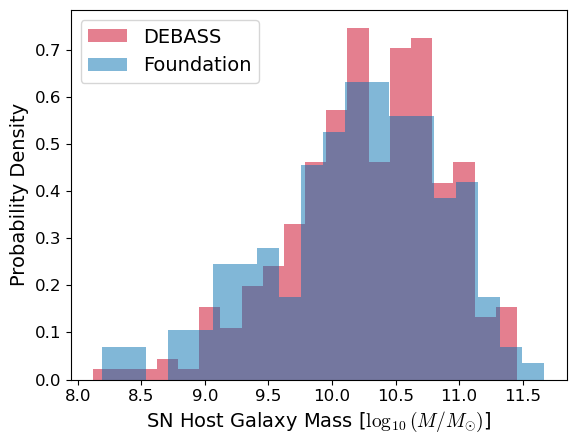

In [79]:
FN_Host_Properties = pd.read_csv('FN_Host_Properties.csv')
DEBASS_allHost = pd.read_csv('DEBASS_allHost.csv')
plt.hist(DEBASS_allHost['LOGMASS'], color='#ca0020',density=True,bins=20, alpha=0.5, label='DEBASS')
plt.hist(FN_Host_Properties['LOGMASS'],color='#0571b0',density=True, bins=20, alpha=0.5, label='Foundation')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('SN Host Galaxy Mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
plt.ylabel('Probability Density',fontsize=14) 
plt.tick_params(labelsize = 12)
#plt.savefig('DEBASS_FN_M_hist.pdf')
print('DEBASS median:', np.median(DEBASS_allHost['LOGMASS']))
print('Foundation median:', np.median(FN_Host_Properties['LOGMASS']))

## Compare with Childress mass distribution model

(0.0, 1.0)

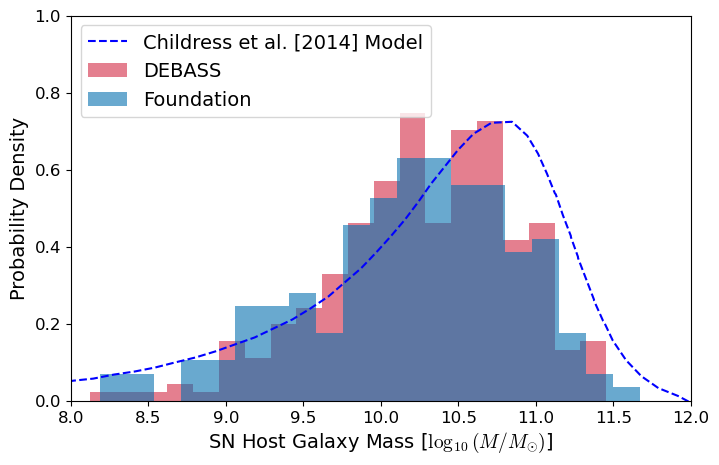

In [80]:
Mass_model = pd.read_csv('Model Prediction.csv')
plt.figure(figsize=(8,5)) 
plt.plot(Mass_model['Mass']+0.2,Mass_model['Number']/1.3,'--',label='Childress et al. [2014] Model',color='blue')
plt.hist(DEBASS_allHost['LOGMASS'], color='#ca0020',density=True,bins=20, alpha=0.5, label='DEBASS')
plt.hist(FN_Host_Properties['LOGMASS'],color='#0571b0', density=True,bins=20,alpha=0.6, label='Foundation')
#plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.legend(loc='upper left',fontsize=14)
plt.xlabel('SN Host Galaxy Mass [$\log_{10}(M / M_{\odot})$]',fontsize=14)
plt.ylabel('Probability Density',fontsize=14) 
plt.tick_params(labelsize = 12)
plt.xlim(8,12)
plt.ylim(0,1.0)
#plt.savefig('M vs Model.pdf')

## Statistical Analysis

Using the Kolmogorov-Smirnov test, we can compare the mass distributions of the two samples. The null hypothesis is that the two samples are drawn from the same distribution. The p-value is the probability of observing a test statistic as extreme as the one computed from the data, assuming that the null hypothesis is true. If the p-value is less than the significance level (0.05), we reject the null hypothesis and conclude that the two samples are drawn from different distributions.

$$H_0: \text{The two samples are drawn from the same distribution.}$$
$$H_1: \text{The two samples are drawn from different distributions.}$$


In [82]:
ks_2samp(list(DEBASS_allHost['LOGMASS']), list(FN_Host_Properties['LOGMASS']))

KstestResult(statistic=0.07547127669078889, pvalue=0.5682223744274552, statistic_location=9.546, statistic_sign=-1)

# (U-R) color

In [84]:
def computeColour(SED, filter1, filter2, system="AB", Vega=None):
    c=conts.c.value
    h=(conts.h).value
    # We compute the AB magnitudes by default
    # One can add Vega magnitudes if needed
    # Interpolate the SED and filter curves over steps in wavelength
    
    # Filter 1
    wmin=np.min(filter1['wavelength'])
    wmax=np.max(filter1['wavelength'])
    wstep=1.0
    
    wavelength1=np.arange(wmin,wmax+wstep,wstep)
    
    T_filter1=interp1d(filter1['wavelength'],filter1['transmission'],
                       bounds_error=False, fill_value=0.0)(wavelength1)
 
    SED_interp=interp1d(SED['wavelength'],SED['luminosity'],
                       bounds_error=False, fill_value=0.0)(wavelength1)
    
    
    # Compute the upper intergral
    upper=trapezoid(SED_interp * T_filter1 / c / h * wavelength1,wavelength1)
    
    # Compute the lower intergral
    if system == "AB":
        lower=trapezoid(3631e-23 * T_filter1 / c / h * wavelength1,wavelength1)
    else:
        Vega_interp=interp1d(Vega['wavelength'],Vega['luminosity'],
                       bounds_error=False, fill_value=0.0)(wavelength1)
    
        lower=trapezoid( Vega_interp * T_filter1 / c / h * wavelength1,wavelength1)   
 
    mag1=-2.5*np.log10(upper/lower)
    

    # Filter 2
    wmin=np.min(filter2['wavelength'])
    wmax=np.max(filter2['wavelength'])
    wstep=1.0

    wavelength2=np.arange(wmin,wmax+wstep,wstep)
    
    T_filter2=interp1d(filter2['wavelength'],filter2['transmission'],
                       bounds_error=False, fill_value=0.0)(wavelength2)

    SED_interp=interp1d(SED['wavelength'],SED['luminosity'],
                       bounds_error=False, fill_value=0.0)(wavelength2)


    # Compute the intergrals
    upper=trapezoid(SED_interp * T_filter2 / c / h * wavelength2, wavelength2)

    
    # Compute the lower intergral
    if system == "AB":
        lower=trapezoid(3631e-23 * T_filter2 / c / h * wavelength2,wavelength2)
    else:
        Vega_interp=interp1d(Vega['wavelength'],Vega['luminosity'],
                       bounds_error=False, fill_value=0.0)(wavelength2)
    
        lower=trapezoid(Vega_interp  * T_filter2 / c / h * wavelength2,wavelength2)
    
    mag2=-2.5*np.log10(upper/lower)
 
    colour=mag1-mag2
    
    return colour


In [97]:
def ApplycomputeColour(folderPath):
    # Used Bessell filter curves used in SALT2
    u_filter="sux.dat" 
    r_filter="sr.dat"
    Vega="alpha_lyr_stis_005.ascii"

    Vega=np.genfromtxt(Vega, names = ['wavelength','luminosity'])
    u_filterCurve=np.genfromtxt(u_filter, names = ['wavelength','transmission'])
    r_filterCurve=np.genfromtxt(r_filter, names = ['wavelength','transmission'])


    # Contains the best-fitting SED files for each host galaxy
    results = []
    for filename in os.listdir(folderPath):
        if filename.endswith('.txt'):
            SED=np.genfromtxt(os.path.join(folderPath, filename), names = ['wavelength','luminosity'])
            colour=computeColour(SED, u_filterCurve, r_filterCurve, "Vega", Vega=Vega)
            results.append((filename[:-4], colour))

    Host_color_Vega = pd.DataFrame(results, columns=['snid', 'u-r Color'])
    return Host_color_Vega

In [105]:
Host_color_Vega_DEBASS = ApplycomputeColour(folderPath="DEBASS_sedfittingDATA")
Host_color_Vega_FN = ApplycomputeColour(folderPath="sedfitting_data")

DEBASS median ~ 1.011
Foundation median ~ 1.073


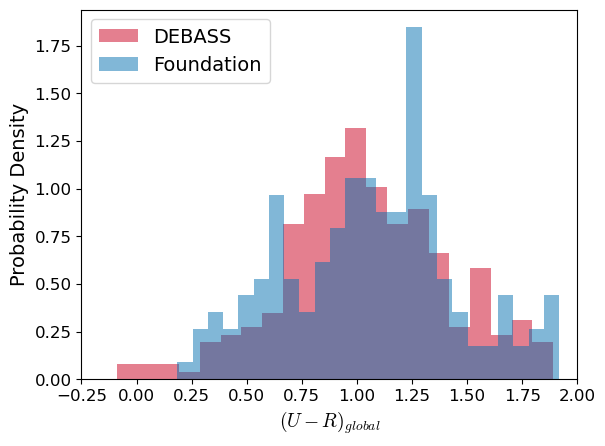

In [107]:
#Host_color_Vega = pd.read_csv('DEBASS_color_Vega.csv')
plt.hist(Host_color_Vega_DEBASS['u-r Color'], bins=25, density=True, histtype='stepfilled', alpha=0.5,color='#ca0020')
plt.hist(Host_color_Vega_FN['u-r Color'], bins=25,density=True, histtype='stepfilled', alpha=0.5,color='#0571b0')
plt.xlabel('$(U-R)_{global}$',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.xlim(-0.25,2.0)
plt.legend(['DEBASS','Foundation'],loc='upper left',fontsize=14)
plt.tick_params(labelsize = 12)
#plt.savefig('DEBASS_FN_color_hist.pdf')
print('DEBASS median ~ %4.3f' %np.median(Host_color_Vega_DEBASS['u-r Color']))
print('Foundation median ~ %4.3f' %np.median(Host_color_Vega_FN['u-r Color']))

In [109]:
ks_2samp(list(Host_color_Vega_DEBASS['u-r Color']), list(Host_color_Vega_FN['u-r Color']))

KstestResult(statistic=0.08844813722862503, pvalue=0.3716682399061995, statistic_location=1.0219578219081598, statistic_sign=1)

# dDLR

In [ ]:
# Load required files
FN_Host_properties = pd.read_csv('FN_Host_properties.csv')
DEBASS_allHost = pd.read_csv('DEBASS_allHost.csv')

# Shape parameters are measured from the global photometry
FN_low_thresh = pd.read_csv('FN_shape_low_threshold2.csv')
DEBASS_low_thresh = pd.read_csv('DEBASS_shape_low_threshold.csv')

In [ ]:
def AngularSep(SN_RA, SN_DEC, HOST_RA, HOST_DEC): # Compute the angular separation between the SN and the host
    deg2rad=np.pi / 180.

    delta_RA=(SN_RA-HOST_RA)*np.cos(SN_DEC * deg2rad)
    delta_DEC=SN_DEC-HOST_DEC

    # The separation of the SN from the host (arcsec)
    ANG_SEP = (np.sqrt(delta_RA**2+delta_DEC**2))*(u.deg).to(u.arcsec)

    # The position angle of the SN on the sky relative to the host (radians) !!
    PA_SN=np.arctan2(delta_DEC,-delta_RA)-np.pi/2
    
    return ANG_SEP, PA_SN

In [ ]:
def dDLR(file, shapefile): 
    # Define the SN and host positions
    SN_RA = np.array(file['SN_RA'])
    SN_DEC = np.array(file['SN_DEC'])
    HOST_RA = np.array(file['HOST_RA'])	
    HOST_DEC = np.array(file['HOST_DEC'])

    # Angular separation and position angle of the SN relative to the host
    ANG_SEP, PA_SN = AngularSep(SN_RA, SN_DEC, HOST_RA, HOST_DEC)

    # Pixel scale using PS1 images from the riz coadd
    # Use 2021dha as an example
    # Assumes all images have the same pixel scale (they actuall do have very similar pixel scales)
    obj_dir = os.path.join(workdir, '2021dha')
    obj_PS1fits = os.path.join(obj_dir, f"{'PS1'}_{'riz'}.fits")
    img_wcs_PS1=WCS.WCS(fitsio.read_header(obj_PS1fits), naxis=2)
    pixel_scale_PS1 = img_wcs_PS1.proj_plane_pixel_scales()[0].to(u.arcsec)

    # Convert the semi-major and semi-minor axes to arcsec
    semi_major=shapefile['a']*pixel_scale_PS1
    semi_minor=shapefile['b']*pixel_scale_PS1
    
    # Assume all PS1 images have the same angle on sky - this needs to be tested
    # The PA of the major axis  !!!
    rot_offset= np.pi / 2.
    PA=shapefile['theta']+rot_offset 

    # The angular offset between the SN and the host's major acis
    delta_PA=PA_SN-PA

    # Directional Light Radius (DLR) in arcsec
    DLRs = (semi_major*semi_minor)/(np.sqrt((semi_major*np.sin(delta_PA))**2 + (semi_minor*np.cos(delta_PA))**2))

    # Dimensionless dDLR
    dDLR=ANG_SEP/DLRs

    return dDLR

DEBASS median ~ 1.288
Foundation median ~ 1.412


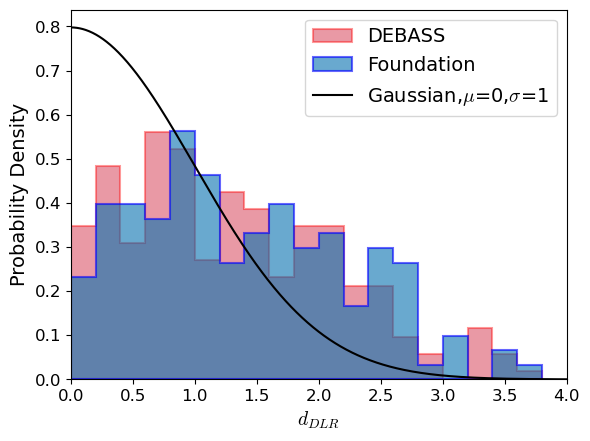

In [ ]:
DEBASS_dDLR = dDLR(DEBASS_allHost, DEBASS_low_thresh)
FN_dDLR = dDLR(FN_Host_properties, FN_low_thresh)

plt.hist(DEBASS_dDLR, bins=np.arange(0,4,0.2), density=True, stacked = True, histtype='stepfilled', alpha=0.4,color='#ca0020',edgecolor='r', linewidth=1.5,align='mid',label='DEBASS')   
plt.hist(FN_dDLR, bins=np.arange(0,4,0.2),density=True,stacked = True, histtype='stepfilled', alpha=0.6,color='#0571b0',edgecolor='b', linewidth=1.5,align='mid',label='Foundation')
plt.xlabel('$d_{DLR}$',fontsize=14)
plt.ylabel('Probability Density',fontsize=14)
plt.xlim(0,4.0)
# Define Gaussian function
# This needs to be a one-sided Guassian
def gaussian(x, mean, sigma):
    return (2./(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / sigma)**2)

# Generate x values for the Gaussian curve
x = np.linspace(0,4, 1000)

plt.plot(x, gaussian(x, 0, 1), label='Gaussian,$\mu$=0,$\sigma$=1',color='black')
# plt.plot(x, gaussian(x, 0, np.median(dDLR)), label='Gaussian_2')
plt.legend(fontsize=14)
plt.tick_params(labelsize = 12)
#plt.savefig('DEBASS_FN_dDLR_hist.pdf')
print('DEBASS median ~ %4.3f' %np.median(DEBASS_dDLR))
print('Foundation median ~ %4.3f' %np.median(FN_dDLR))